Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работ:

- 1. [Анализ данных](#the_destination01)
- 2. [Подготавливаем к обучению](#the_destination02)
- 3. [Обучение](#the_destination03)
    - 3.1 [LightGBM](#the_destination04)
    - 3.2 [CLF](#the_destination05)
    - 3.3 [REG](#the_destination06)
    - 3.4 [Dummy](#the_destination07)
- 4. [Вывод](#the_destination08)

# 1. Анализ данных<a id='the_destination01'></a>

In [246]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler

from lightgbm import LGBMRegressor

df = pd.read_csv('/datasets/autos.csv')
state = np.random.RandomState(21)

np.set_printoptions(precision=3)
sns.set()

Функция `column_info` показывает информацию по столбцу.

In [247]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `bar_chart` отображает информацию в виде баров в минималистичном виде.

In [248]:
def bar_chart(array, column_names, title, color='mediumseagreen', figsize=(6,4)):
    plt.figure(figsize=figsize)    
    n = len(array)
    
    bars = plt.bar(np.arange(n), array, color=color)
    
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.{1}f}'.format(height, 2), 
                     ha='center', color='black', fontsize=11)

    plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, labelbottom=True) 
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks(range(n), column_names, alpha=0.8);
    plt.title(title, alpha=0.8)

Функция `wise_fillna` заполняет nan средним или медианой по соотвествующим категориям из другого выбранного столбца.

In [249]:
def wise_fillna(data, column_out, column_in, quantitative=False, mean=True):
    if quantitative:
        if mean:            
            for i in data[column_in].unique():
                mean = data.loc[data[column_in]==i, column_out].mean()
                data.loc[data[column_in]==i, column_out] = data.loc[data[column_in]==i, column_out].fillna(mean)
            data[column_out] = data[column_out].fillna(data[column_out].mean())  
        else:
            for i in data[column_in].unique():
                median = data.loc[data[column_in]==i, column_out].median()
                data.loc[data[column_in]==i, column_out] = data.loc[data[column_in]==i, column_out].fillna(median)
            data[column_out] = data[column_out].fillna(data[column_out].median())
    else:    
        for i in data[column_in].unique():
            most_freq = data.loc[data[column_in]==i, column_out].value_counts().index[0]
            data.loc[data[column_in]==i, column_out] = data.loc[data[column_in]==i, column_out].fillna(most_freq)

In [250]:
df.columns = [i.lower() for i in df.columns]

Смотрим глазами. Всё норм, есть nan-ы, куда без них.

In [251]:
df.sample(n=10, random_state=state)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
229435,2016-03-20 22:39:34,7399,coupe,2000,manual,193,3er,150000,4,petrol,bmw,no,2016-03-20 00:00:00,0,44575,2016-04-01 11:44:37
287627,2016-03-30 16:53:47,6999,wagon,2007,manual,140,passat,150000,1,gasoline,volkswagen,no,2016-03-30 00:00:00,0,30419,2016-04-07 08:16:42
147772,2016-03-18 17:06:42,14200,suv,2006,auto,0,q7,150000,9,gasoline,audi,no,2016-03-18 00:00:00,0,56070,2016-03-23 18:16:16
304671,2016-03-07 15:53:22,3800,other,2004,manual,136,other,5000,0,gasoline,peugeot,NaN,2016-03-07 00:00:00,0,60389,2016-04-05 19:44:40
72292,2016-03-09 22:49:57,1800,sedan,2001,auto,101,focus,80000,1,petrol,ford,NaN,2016-03-09 00:00:00,0,45144,2016-03-10 09:44:15
20677,2016-03-09 14:52:39,6399,wagon,2005,manual,150,3er,150000,11,petrol,bmw,no,2016-03-09 00:00:00,0,48703,2016-03-12 13:45:12
282600,2016-03-23 12:49:48,400,sedan,1995,NaN,0,golf,60000,11,petrol,volkswagen,yes,2016-03-23 00:00:00,0,13055,2016-04-05 12:45:06
48662,2016-03-24 13:56:21,14990,coupe,1974,auto,185,other,150000,10,petrol,mercedes_benz,no,2016-03-24 00:00:00,0,72379,2016-04-07 05:46:38
341088,2016-03-25 22:51:20,3500,sedan,1991,manual,150,3er,150000,10,petrol,bmw,no,2016-03-25 00:00:00,0,27574,2016-04-05 12:44:52
245084,2016-03-14 15:47:21,2500,wagon,2003,manual,163,a4,150000,10,gasoline,audi,no,2016-03-14 00:00:00,0,21266,2016-03-26 09:17:04


Смотрим, где ждать nan-ы.

In [252]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

`datecrawled` - дата и время, когда были просканированы данные. Нам такое не нужно.

In [253]:
df.drop('datecrawled', axis=1, inplace=True)

Смотрим глазами на строки с аномально низкими ценами. Не видим ничего особенного.

In [254]:
df[df.price < 50].sample(n=10, random_state=state)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
135104,0,NaN,1990,manual,0,NaN,80000,3,NaN,trabant,NaN,2016-03-29 00:00:00,0,58802,2016-04-06 04:45:48
221803,0,NaN,2016,manual,150,astra,150000,9,gasoline,opel,NaN,2016-04-03 00:00:00,0,26427,2016-04-03 20:57:22
179234,0,small,1998,manual,54,corsa,150000,0,NaN,opel,NaN,2016-03-28 00:00:00,0,42555,2016-04-04 19:47:06
15361,0,wagon,1995,manual,116,3er,150000,11,petrol,bmw,NaN,2016-03-19 00:00:00,0,4924,2016-04-06 13:17:12
210004,0,convertible,2001,manual,101,NaN,150000,2,petrol,opel,no,2016-03-17 00:00:00,0,49477,2016-03-19 11:16:27
336877,0,NaN,2000,NaN,0,arosa,150000,0,NaN,seat,NaN,2016-03-10 00:00:00,0,74363,2016-03-11 12:47:52
32395,0,other,1991,auto,0,NaN,30000,0,NaN,sonstige_autos,yes,2016-03-20 00:00:00,0,31812,2016-03-23 22:47:22
78274,20,NaN,1995,NaN,0,80,5000,0,NaN,audi,NaN,2016-03-06 00:00:00,0,47475,2016-04-06 20:44:54
333566,0,NaN,2016,manual,58,twingo,150000,6,petrol,renault,NaN,2016-04-01 00:00:00,0,47057,2016-04-05 18:18:35
68719,1,NaN,2015,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-09 00:00:00,0,41564,2016-03-09 14:43:11


Смотрим, сколько процентов строк с аномально низкой ценой.

In [255]:
print('Процент авто с ценой, меньшей 50 евро {:.2%}'.format(len(df[df.price < 50]) / len(df)))

Процент авто с ценой, меньшей 50 евро 3.51%


Это всё таки целевой признак, тут нужно быть максимсально точным. Процент авто с деффектной ценой терпимый, так что предпочту это просто удалить из ДФ.

In [256]:
df = df[df.price >= 50]

Столбец `price`. Смотрим, что получилось. Всё в порядке.


*** Информация по столбцу price ***

Тип данных столбца price: int64:
В столбце price пропущено 0 из 341946 строк, что составляет 0.00%
Минимальное значение: 50.00
Максимальное значение: 20000.00
Среднее значение: 4577.08
Медианное значение: 2900.00


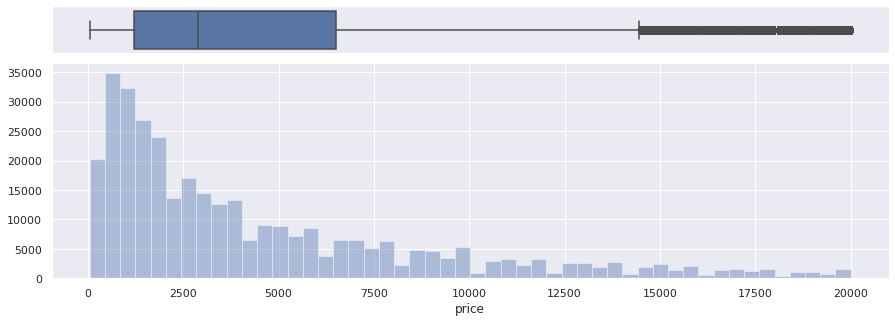

In [257]:
column_info(df, 'price', quantitative=True)

Столбец `model`. Заполняем nan-ы значением `unknown`.

In [258]:
column_info(df, 'model')


*** Информация по столбцу model ***

Тип данных столбца model: object:
В столбце model пропущено 17163 из 341946 строк, что составляет 5.02%

Количество значений в каждой из категорий:
golf                  28138
other                 23568
3er                   19092
polo                  12572
corsa                 12137
                      ...  
i3                        8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64



In [259]:
df.model.fillna('unknown', inplace=True)

Столбец `vehicletype`. Заполняем nan-ы "умным заполнителем", опираясь на категории из столбца `model`. Предполагаем, что характеристики у автомобилей по моделям примерно одинаковые.

In [260]:
column_info(df, 'vehicletype')


*** Информация по столбцу vehicletype ***

Тип данных столбца vehicletype: object:
В столбце vehicletype пропущено 32979 из 341946 строк, что составляет 9.64%

Количество значений в каждой из категорий:
sedan          89169
small          77792
wagon          63524
bus            28272
convertible    19820
coupe          15568
suv            11766
other           3056
Name: vehicletype, dtype: int64



In [261]:
wise_fillna(df, 'vehicletype', 'model')

Беда с годами. Пытаемся понять какая и исправить это. Едва ли у нас имеются автомобили до 1900 года и после 2020 года. Надо эти машины времени убрать, их не так уж и много.

In [262]:
print('Неадекватные года: {:.2%}'.format(len(df[(df.registrationyear < 1900) | (df.registrationyear > 2020)]) / len(df)))

Неадекватные года: 0.04%


In [263]:
df = df[(df.registrationyear >= 1900) & (df.registrationyear <= 2020)]

Столбец `registrationyear`. Смотрим, что получилось. Всё в порядке.


*** Информация по столбцу registrationyear ***

Тип данных столбца registrationyear: int64:
В столбце registrationyear пропущено 0 из 341819 строк, что составляет 0.00%
Минимальное значение: 1910.00
Максимальное значение: 2019.00
Среднее значение: 2003.20
Медианное значение: 2003.00


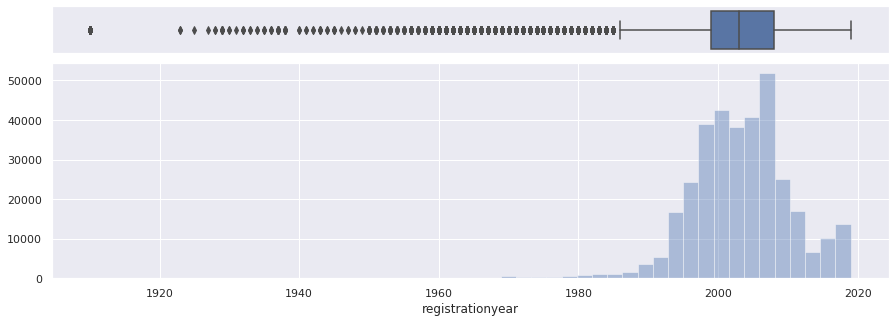

In [264]:
column_info(df, 'registrationyear', quantitative=True)

Столбец `gearbox`. Заполняем nan-ы "умным заполнителем", опираясь на категории из столбца `model`. Предполагаем, что характеристики у автомобилей по моделям примерно одинаковые.

In [265]:
column_info(df, 'gearbox')
wise_fillna(df, 'gearbox', 'model')


*** Информация по столбцу gearbox ***

Тип данных столбца gearbox: object:
В столбце gearbox пропущено 16563 из 341819 строк, что составляет 4.85%

Количество значений в каждой из категорий:
manual    260571
auto       64685
Name: gearbox, dtype: int64



С мощностью тоже не всё в порядке. Исправлем это теми же подходами.

In [266]:
print('Неадекватная мощность: {:.2%}'.format(len(df[(df.power < 5) | (df.power > 2000)]) / len(df)))

Неадекватная мощность: 10.42%


In [267]:
df.loc[df.power == 0, 'power'] = np.nan
df.loc[df.power >= 1000, 'power'] = np.nan

In [268]:
wise_fillna(df, 'power', 'model', quantitative=True, mean=False)

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Столбец `power`. Смотрим, что получилось. Всё в порядке.


*** Информация по столбцу power ***

Тип данных столбца power: float64:
В столбце power пропущено 0 из 341819 строк, что составляет 0.00%
Минимальное значение: 1.00
Максимальное значение: 999.00
Среднее значение: 118.94
Медианное значение: 109.00


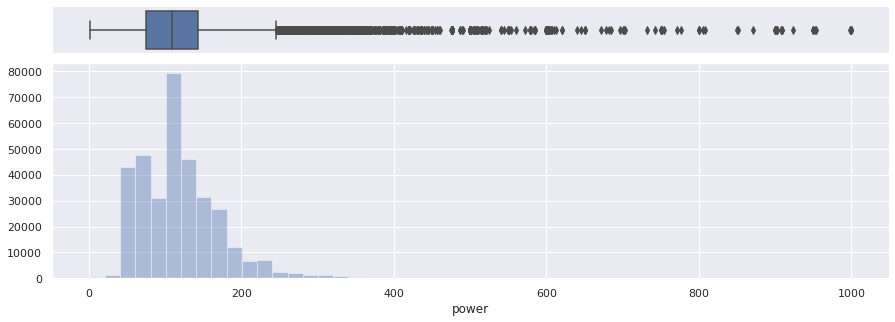

In [269]:
column_info(df, 'power', quantitative=True)

С пробегом тоже беда. Почему-то 67.16% авто с одним пробегом 150000. Возможно, это ограничение сервиса, но выглядит странно. Тем не менее характеристика важная для определения цены поддержанного автомобился, так что придётся оставить.


*** Информация по столбцу kilometer ***

Тип данных столбца kilometer: int64:
В столбце kilometer пропущено 0 из 341819 строк, что составляет 0.00%
Минимальное значение: 5000.00
Максимальное значение: 150000.00
Среднее значение: 128500.19
Медианное значение: 150000.00


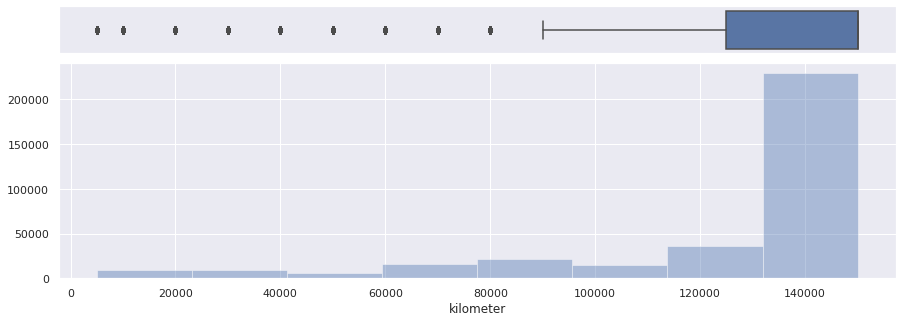

In [270]:
column_info(df, 'kilometer', quantitative=True, bins=8)

In [271]:
print('Неадекватный пробег: {:.2%}'.format(len(df[df.kilometer == 150000]) / len(df)))

Неадекватный пробег: 67.16%


Столбец `registrationmonth` нам не нужен. От него не должно много зависеть.

In [272]:
df.drop('registrationmonth', axis=1, inplace=True)

Столбец `fueltype`. Всё то же самое.

In [273]:
wise_fillna(df, 'fueltype', 'model')

In [274]:
column_info(df, 'fueltype')


*** Информация по столбцу fueltype ***

Тип данных столбца fueltype: object:
В столбце fueltype пропущено 0 из 341819 строк, что составляет 0.00%

Количество значений в каждой из категорий:
petrol      234513
gasoline    101134
lpg           5155
cng            549
hybrid         226
other          155
electric        87
Name: fueltype, dtype: int64



Тут всё ок.

In [275]:
column_info(df, 'brand')


*** Информация по столбцу brand ***

Тип данных столбца brand: object:
В столбце brand пропущено 0 из 341819 строк, что составляет 0.00%

Количество значений в каждой из категорий:
volkswagen        74060
opel              38315
bmw               35585
mercedes_benz     31209
audi              28438
ford              24353
renault           17315
peugeot           10741
fiat               9295
seat               6696
mazda              5445
skoda              5429
smart              5151
citroen            4999
nissan             4791
toyota             4526
hyundai            3523
mini               3160
volvo              3111
mitsubishi         2912
honda              2704
sonstige_autos     2702
kia                2403
suzuki             2270
alfa_romeo         2215
chevrolet          1700
chrysler           1359
dacia               888
daihatsu            773
subaru              726
porsche             708
jeep                653
land_rover          533
daewoo              530
sa

Столбец `notrepaired`. Заполняем nan-ы значением `unknown`.

In [276]:
column_info(df, 'notrepaired')


*** Информация по столбцу notrepaired ***

Тип данных столбца notrepaired: object:
В столбце notrepaired пропущено 64756 из 341819 строк, что составляет 18.94%

Количество значений в каждой из категорий:
no     243310
yes     33753
Name: notrepaired, dtype: int64



In [277]:
df.notrepaired.fillna('unknown', inplace=True)

Дата создания объявления нам тут не нужна.

In [278]:
df.drop('datecreated', axis=1, inplace=True)

Картинок везде 0. Избавляемся от этого столбца.

In [279]:
column_info(df, 'numberofpictures')


*** Информация по столбцу numberofpictures ***

Тип данных столбца numberofpictures: int64:
В столбце numberofpictures пропущено 0 из 341819 строк, что составляет 0.00%

Количество значений в каждой из категорий:
0    341819
Name: numberofpictures, dtype: int64



In [280]:
df.drop('numberofpictures', axis=1, inplace=True)

С почтовыми индексами (то есть с географией) всё в порядке.

In [281]:
column_info(df, 'postalcode', quantitative=True, mean=False, median=False, hist=False)


*** Информация по столбцу postalcode ***

Тип данных столбца postalcode: int64:
В столбце postalcode пропущено 0 из 341819 строк, что составляет 0.00%
Минимальное значение: 1067.00
Максимальное значение: 99998.00



In [282]:
column_info(df, 'postalcode')


*** Информация по столбцу postalcode ***

Тип данных столбца postalcode: int64:
В столбце postalcode пропущено 0 из 341819 строк, что составляет 0.00%

Количество значений в каждой из категорий:
10115    811
65428    603
66333    324
44145    301
32257    300
        ... 
29496      1
78345      1
6638       1
94359      1
24638      1
Name: postalcode, Length: 8138, dtype: int64



In [283]:
df.drop('postalcode', axis=1, inplace=True)

Информация о том, когда владелец последний раз был на сайте, ничего с цене автомобиля не добавляет.

In [284]:
df.drop('lastseen', axis=1, inplace=True)

Смотрим, что получилось.

In [285]:
df.sample(n=10, random_state=state)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
288045,1500,wagon,2000,manual,125.0,forester,150000,petrol,subaru,no
253846,5500,bus,2007,manual,111.0,scenic,60000,petrol,renault,no
2977,700,suv,1998,auto,204.0,other,150000,petrol,ford,yes
152067,1450,small,2002,manual,75.0,corsa,150000,petrol,opel,no
52241,8750,suv,2004,auto,163.0,xc_reihe,150000,gasoline,volvo,no
345796,6801,sedan,2009,manual,170.0,a6,100000,gasoline,audi,unknown
321041,390,small,1996,manual,44.0,corsa,150000,petrol,opel,unknown
310820,2900,wagon,2001,manual,179.0,other,150000,gasoline,audi,yes
171677,2499,sedan,1999,manual,170.0,3er,150000,petrol,bmw,yes
207384,10600,suv,2007,auto,340.0,cayenne,150000,petrol,porsche,no


Nan-ов нет.

In [286]:
df.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
notrepaired         0
dtype: int64

Сильной корреляции также не наблюдается.

In [287]:
df.corr()

,price,registrationyear,power,kilometer
price,1.000000,0.377731,0.496127,-0.358419
registrationyear,0.377731,1.000000,0.096374,-0.194026
power,0.496127,0.096374,1.000000,0.099286
kilometer,-0.358419,-0.194026,0.099286,1.000000


In [288]:
df.duplicated().sum()

48399

In [289]:
df.drop_duplicates(inplace=True)

In [290]:
df.duplicated().sum()

0

In [291]:
df.shape

(293420, 10)

# 2. Подготавливаем в обучению<a id='the_destination02'></a>

Переводим категориальные переменные в цифру.

In [292]:
categorical_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
# quantitative_features = ['registrationyear', 'power', 'kilometer', 'postalcode']

In [293]:
df_ordinal = df.copy()

In [294]:
encoder = OrdinalEncoder()

In [295]:
df_ordinal[categorical_features] = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=categorical_features,
                                                index=df.index)

In [296]:
df_ordinal_20000 = df_ordinal.sample(n=20000, random_state=state).reset_index()

Выделяем целевой признак `price`.

In [297]:
df_ordinal_features = df_ordinal_20000.drop('price', axis=1)

In [298]:
df_ordinal_target = df_ordinal_20000.price

Делим выборку на обучающую и тестовую.

In [299]:
X_train, X_test, y_train, y_test = train_test_split(df_ordinal_features, df_ordinal_target, random_state=state)

Приводим все обучающие признаки к одному масштабу.

In [300]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# 3. Обучение<a id='the_destination01'></a>

Создаём скорер из метрики.

In [301]:
def scorer(original, predicted):        
    return mean_squared_error(original, predicted) ** .5

scorer = make_scorer(scorer, greater_is_better=False)

### 3.1 LightGBM<a id='the_destination04'></a>

Ищём оптимальные параметры из небольшого списка.

In [302]:
lgb_model = LGBMRegressor()

parameters = {'learning_rate': [0.1, 0.5],              
              'n_estimators': [200, 300],
              'max_depth': [5, 10],
              'num_leaves': [25, 50]
              }

grid_lgb = GridSearchCV(estimator=lgb_model, param_grid=parameters, cv=3, scoring=scorer)
grid_lgb.fit(X_train, y_train)

print('Лучший rmse среди всех параметров:', -grid_lgb.best_score_)
print('Лучшие параметры:', grid_lgb.best_params_)

Лучший rmse среди всех параметров: 1918.2393701152068
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 25}


Засекаем время.

In [303]:
time_start = time.time()

lgb_model = LGBMRegressor(learning_rate=0.1, n_estimators=300, max_depth=10, num_leaves=50)
lgb_model.fit(X_train, y_train)

lgb_train_time = time.time() - time_start
print('Время обучения lgb-модели: {:.3f}'.format(lgb_train_time))

Время обучения lgb-модели: 5.302


In [304]:
time_start = time.time()

lgb_predictions = lgb_model.predict(X_test)

lgb_prediction_time = time.time() - time_start
print('Время предсказания lgb-модели: {:.23}'.format(lgb_prediction_time))

Время предсказания lgb-модели: 0.297045230865478515625


Смотрим качество.

In [305]:
rsme_lgb = mean_squared_error(y_test, lgb_predictions) ** .5
print('rsme lgb на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train, lgb_model.predict(X_train)) ** .5))
print('rsme lgb на тестовой выборке: {:.2f}'.format(rsme_lgb))

rsme lgb на обучающей выборке: 1235.97
rsme lgb на тестовой выборке: 1866.26


### 3.2 CLF<a id='the_destination05'></a>

Ищём оптимальные параметры из небольшого списка.

In [306]:
clf_model = GradientBoostingRegressor(random_state=state)

parameters = {'learning_rate': [0.1, 0.5],              
              'n_estimators': [40,80],
              'max_depth': [3, 5]
              }

grid_clf = GridSearchCV(estimator=clf_model, param_grid=parameters, cv=3, scoring=scorer)
grid_clf.fit(X_train, y_train)

print('Лучший rmse среди всех параметров:', -grid_clf.best_score_)
print('Лучшие параметры:', grid_clf.best_params_)

Лучший rmse среди всех параметров: 1960.4729985133558
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}


Засекаем время.

In [307]:
time_start = time.time()

clf_model = GradientBoostingRegressor(learning_rate=.5, max_depth=5, n_estimators=80, random_state=state)
clf_model.fit(X_train, y_train)

clf_train_time = time.time() - time_start
print('Время обучения clf-модели: {:.3f}'.format(clf_train_time))

Время обучения clf-модели: 1.424


In [308]:
time_start = time.time()

clf_predictions = clf_model.predict(X_test)

clf_prediction_time = time.time() - time_start
print('Время предсказания clf-модели: {:.3f}'.format(clf_prediction_time))

Время предсказания clf-модели: 0.013


Смотрим качество.

In [309]:
rsme_clf = mean_squared_error(y_test, clf_predictions) ** .5
print('rsme clf на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train, clf_model.predict(X_train)) ** .5))
print('rsme clf на тестовой выборке: {:.2f}'.format(rsme_clf))

rsme clf на обучающей выборке: 1275.62
rsme clf на тестовой выборке: 1985.74


### 3.3 REG<a id='the_destination06'></a>

Засекаем время.

In [310]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, drop_first=True, columns=categorical_features)

df_ohe_features = df_ohe.drop('price', axis=1)
df_ohe_target = df_ohe.price

scaler = MinMaxScaler()
df_ohe = pd.DataFrame(scaler.fit_transform(df_ohe), index=df_ohe.index, columns = df_ohe.columns)

X_train, X_test, y_train, y_test = train_test_split(df_ohe_features, df_ohe_target, random_state=state)

In [311]:
time_start = time.time()

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

reg_train_time = time.time() - time_start
print('Время обучения reg-модели: {:.3f}'.format(reg_train_time))

Время обучения reg-модели: 21.746


In [312]:
time_start = time.time()

reg_predictions = reg_model.predict(X_test)

reg_prediction_time = time.time() - time_start
print('Время предсказания reg-модели: {:.3}'.format(reg_prediction_time))

Время предсказания reg-модели: 0.145


Смотрим качество.

In [313]:
rsme_reg = mean_squared_error(y_test, reg_predictions) ** .5
print('rsme reg на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train, reg_model.predict(X_train)) ** .5))
print('rsme reg на тестовой выборке: {:.2f}'.format(rsme_reg))

rsme reg на обучающей выборке: 2818.40
rsme reg на тестовой выборке: 2806.48


Как бы переобучение, но, видимо, из-за специфики алгоритма, такое бывает. Чтобы этого избежать, можно повышать `n_neighbors` в разумных пределах.

### 3.4 Dummy<a id='the_destination07'></a>

Проверяем на адекватность. 

In [314]:
time_start = time.time()

dummy_model = DummyRegressor(strategy='median')

dummy_model.fit(X_train, y_train)

dummy_train_time = time.time() - time_start
print('Время обучения dummy-модели: {:.3f}'.format(dummy_train_time))

Время обучения dummy-модели: 0.003


In [315]:
time_start = time.time()

dummy_predictions = dummy_model.predict(X_test)

dummy_prediction_time = time.time() - time_start
print('Время предсказания dummy-модели: {:.3f}'.format(dummy_prediction_time))

Время предсказания dummy-модели: 0.000


In [316]:
rsme_dummy = mean_squared_error(y_test, dummy_predictions) ** .5

print('rsme dummy на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train, dummy_model.predict(X_train)) ** .5))
print('rsme dummy на тестовой выборке: {:.2f}'.format(rsme_dummy))

rsme dummy на обучающей выборке: 4875.01
rsme dummy на тестовой выборке: 4910.48


# 4. Вывод<a id='the_destination08'></a>

In [317]:
results = pd.DataFrame({'quality': [rsme_lgb, rsme_clf, rsme_reg, rsme_dummy], 
                        'train_time': [lgb_train_time, clf_train_time, reg_train_time, dummy_train_time],
                        'prediction_time': [lgb_prediction_time, clf_prediction_time, reg_prediction_time, dummy_prediction_time]},
                       index=['lgb', 'clf', 'reg', 'dummy']
                       )

In [318]:
results.sort_values('quality')

,quality,train_time,prediction_time
lgb,1866.258262,5.302299,0.297045
clf,1985.739676,1.424065,0.012510
reg,2806.475848,21.746031,0.144639
dummy,4910.477841,0.003033,0.000486


In [319]:
results.sort_values('quality', inplace=True)

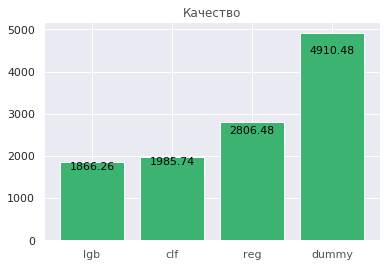

In [320]:
bar_chart(results.quality, results.index, 'Качество')

**Вывод** По качеству победил `lgb`. Все модели заметно лучше `dummy`.

In [321]:
results.sort_values('train_time')

,quality,train_time,prediction_time
dummy,4910.477841,0.003033,0.000486
clf,1985.739676,1.424065,0.012510
lgb,1866.258262,5.302299,0.297045
reg,2806.475848,21.746031,0.144639


In [322]:
results.sort_values('train_time', inplace=True)

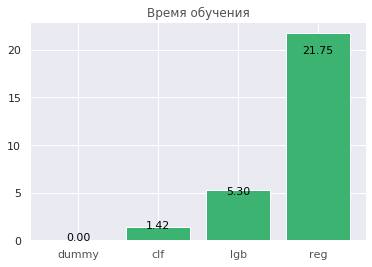

In [323]:
bar_chart(results.train_time, results.index, 'Время обучения')

**Вывод** По времени обучения победил `dummy`, но это не считается. Великое ли дело, медиану посчитать. Среди адекватных моделей победила `lgb`. Ожидаемо, нет никаких итерационных процедур.

In [324]:
results.sort_values('prediction_time')

,quality,train_time,prediction_time
dummy,4910.477841,0.003033,0.000486
clf,1985.739676,1.424065,0.012510
reg,2806.475848,21.746031,0.144639
lgb,1866.258262,5.302299,0.297045


In [325]:
results.sort_values('prediction_time', inplace=True)

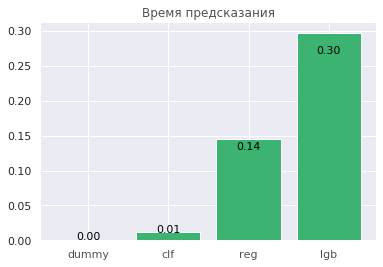

In [326]:
bar_chart(results.prediction_time, results.index, 'Время предсказания')

**Вывод** Предсказывает уже быстрее `clf` среди адекватных моделей. Предсказывает `reg` также заметно быстрее прямымми вычислениеями.

А кто сильнее по совокупности результатов? Приведём все результаты к одной шкале и положим, что качество в два раза важнее времени обучения и времени предсказания.

In [327]:
scaler = MinMaxScaler()
results_final = pd.DataFrame(scaler.fit_transform(results), index=results.index, columns = results.columns)

In [328]:
results_final['final'] = (2 * (1 - results_final['quality']) 
                          + (1 - results_final['train_time']) 
                          + (1 - results_final['prediction_time']))

In [329]:
results_final.sort_values('final', ascending=False)

,quality,train_time,prediction_time,final
clf,0.039249,0.065356,0.040544,3.815603
lgb,0.000000,0.243723,1.000000,2.756277
dummy,1.000000,0.000000,0.000000,2.000000
reg,0.308853,1.000000,0.486083,1.896210


In [330]:
results_final.sort_values('final', ascending=False, inplace=True)

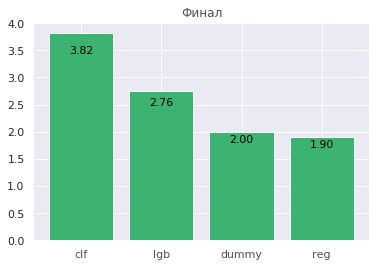

In [331]:
bar_chart(results_final.final, results_final.index, 'Финал')

**Вывод** Модель `clf` победила, набрав из 4 возможных балла 2.89. `lgb` отстала из-за сравнительно невысокой скорости работы, при этом показав лучший результат по предсказанию.